## Elastic Net for Drug Response Prediction

worried of curse of dimensionality with NN, sticking to simpler models 

Why Elastic Net?

- Handles High Dimensionality: Performs feature selection to ignore irrelevant features.
- Avoids Overfitting: Regularization prevents overfitting on small datasets.
- Efficient: Scales well for your dataset size.

In [1]:
%load_ext autoreload
%autoreload 2

### <b> Imports </b>

In [2]:
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from src.data_loader import load_base_data
from src.submission import generate_submission, generate_pdf_with_explanations


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


/Users/schif/anaconda3/envs/ml_env/lib/python3.11/site-packages/fpdf/__init__.py:40: UserWarning: You have both PyFPDF & fpdf2 installed. Both packages cannot be installed at the same time as they share the same module namespace. To only keep fpdf2, run: pip uninstall --yes pypdf && pip install --upgrade fpdf2
  warnings.warn(


### <b> Load Data </b>

In [3]:
x_train, y_train, x_test = load_base_data()

 ### <b> Model Definition </b>

In [4]:
elastic_net = ElasticNet(alpha=0.8, l1_ratio=0.01, random_state=42)

### <b> Scaling and Feature Selection </b>

In [5]:
def spearman_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return spearmanr(y, y_pred).correlation

# scale features
scaler = StandardScaler()
# Train-Test Split
X_train, X_val, Y_train, Y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

X_scaled = scaler.fit_transform(X_train) 
X_val_scaled = scaler.transform(X_val) # WARNING: Only transform, do not fit !!! Was already fitted on training data

# Feature selection
k_best = 500  # Select top 500 features
selector = SelectKBest(mutual_info_regression, k=k_best)
X_scaled = selector.fit_transform(X_scaled, Y_train)
X_val_scaled = selector.transform(X_val_scaled)

In [6]:
def run_elastic_net(X_scaled, y_train, X_val_scaled, Y_test):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    all_y_true = []
    all_y_pred = []

    for train_idx, val_idx in kf.split(X_scaled):
        X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        elastic_net.fit(X_train_fold, y_train_fold)

        y_pred = elastic_net.predict(X_val_fold)
        all_y_true.extend(y_val_fold.values.flatten())
        all_y_pred.extend(y_pred)

    spearman_corr, _ = spearmanr(all_y_true, all_y_pred)
    rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
    r2 = r2_score(all_y_true, all_y_pred)

    print(f"Spearman Correlation (KFold): {spearman_corr}")
    print(f"RMSE (KFold): {rmse}")
    print(f"R-squared (KFold): {r2}")


    elastic_net.fit(X_scaled, Y_train)
    y_test_pred = elastic_net.predict(X_val_scaled)

    spearman_corr_test, _ = spearmanr(Y_test.values.flatten(), y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_pred))
    r2_test = r2_score(Y_test, y_test_pred)

    print(f"Spearman Correlation (Test): {spearman_corr_test}")
    print(f"RMSE (Test): {rmse_test}")
    print(f"R-squared (Test): {r2_test}")

    return spearman_corr_test, rmse_test, r2_test

spearman_corr_test, rmse_test, r2_test = run_elastic_net(X_scaled, Y_train, X_val_scaled, Y_test)


Spearman Correlation (KFold): 0.48439809743056744
RMSE (KFold): 0.09228828273890959
R-squared (KFold): 0.22057399348132856
Spearman Correlation (Test): 0.3745967482286578
RMSE (Test): 0.07784428429521538
R-squared (Test): 0.19053325718865344


### <b> Generate a full submission </b>
assumes already generated Shap plots and LLaMa Generations for this model

In [7]:
generate_submission(elastic_net,x_test, scaler, x_train.columns, selector=selector, filename_csv="elastic_net_submission.csv")

/Users/schif/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(
2024-12-17 23:41:43,583 - INFO - Generating submission file elastic_net_submission.csv
2024-12-17 23:41:43,586 - INFO - Submission file elastic_net_submission.csv has been generated successfully
2024-12-17 23:41:43,587 - INFO - Generating PDF file...
2024-12-17 23:41:44,165 - INFO - PDF generated: explanations.pdf


### <b> Generate submission </b>
predictions csv only 🕺🏽

In [ ]:
# x_test_reduced = pca.transform(x_test)
x_test_scaled = scaler.transform(x_test) 
# x_test_scaled = selector.transform(x_test_scaled)
y_pred = elastic_net.predict(x_test_scaled)

predictions = pd.DataFrame({"sampleId": x_test.index, "AAC": y_pred.flatten()})
predictions["sampleId"] = predictions["sampleId"].apply(lambda x: x.replace("CL", "TS"))
predictions.to_csv("elastid.csv", index=False)

### <u> Find best params for model <u>

In [ ]:
alphas = [i for i in np.linspace(0.1, 1, 10)]
l1_ratios = [i for i in np.linspace(0.1, 1, 10)]
results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid search over alpha and l1_ratio
for alpha in alphas:
    for l1_ratio in l1_ratios:
        all_y_true = []
        all_y_pred = []

        for train_idx, val_idx in kf.split(X_scaled):
            # Train-validation split for current fold
            X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Initialize and train ElasticNet
            elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=5000, random_state=42)
            elastic_net.fit(X_train_fold, y_train_fold)

            # Predict on validation fold
            y_pred = elastic_net.predict(X_val_fold)
            all_y_true.extend(y_val_fold.values.flatten())
            all_y_pred.extend(y_pred)

        # Compute metrics for the current parameter combination
        spearman_corr, _ = spearmanr(all_y_true, all_y_pred)
        r2 = r2_score(all_y_true, all_y_pred)

        # Store results
        results.append({'alpha': alpha, 'l1_ratio': l1_ratio, 'spearman': spearman_corr, 'r2': r2})

        print(f"Alpha: {alpha}, L1 Ratio: {l1_ratio}, Spearman (KFold): {spearman_corr:.4f}, R^2 (KFold): {r2:.4f}")


results_df = pd.DataFrame(results)


best_row = results_df.loc[results_df['spearman'].idxmax()]
print("\nBest Parameters (by Spearman):")
print(f"Alpha: {best_row['alpha']}, L1 Ratio: {best_row['l1_ratio']}")
print(f"Best Spearman Correlation (KFold): {best_row['spearman']:.4f}")
print(f"Best R-squared (KFold): {best_row['r2']:.4f}")


elastic_net = ElasticNet(alpha=best_row['alpha'], l1_ratio=best_row['l1_ratio'], max_iter=5000, random_state=42)
elastic_net.fit(X_scaled, y_train)


y_test_pred = elastic_net.predict(X_val_scaled)
spearman_corr_test, _ = spearmanr(Y_test.values.flatten(), y_test_pred)
rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_pred))
r2_test = r2_score(Y_test, y_test_pred)

print("\nTest Set Evaluation:")
print(f"Spearman Correlation (Test): {spearman_corr_test:.4f}")
print(f"RMSE (Test): {rmse_test:.4f}")
print(f"R-squared (Test): {r2_test:.4f}")


Alpha: 0.001, L1 Ratio: 0.1, Spearman (KFold): 0.1507, R^2 (KFold): -5.5167
Alpha: 0.001, L1 Ratio: 0.3, Spearman (KFold): 0.1626, R^2 (KFold): -2.0148
Alpha: 0.001, L1 Ratio: 0.5, Spearman (KFold): 0.1869, R^2 (KFold): -1.0918
Alpha: 0.001, L1 Ratio: 0.7, Spearman (KFold): 0.1911, R^2 (KFold): -0.7109
Alpha: 0.001, L1 Ratio: 0.9, Spearman (KFold): 0.1958, R^2 (KFold): -0.5087
Alpha: 0.005, L1 Ratio: 0.1, Spearman (KFold): 0.1859, R^2 (KFold): -1.0205
Alpha: 0.005, L1 Ratio: 0.3, Spearman (KFold): 0.2127, R^2 (KFold): -0.2118
Alpha: 0.005, L1 Ratio: 0.5, Spearman (KFold): 0.2305, R^2 (KFold): -0.0348
Alpha: 0.005, L1 Ratio: 0.7, Spearman (KFold): 0.2535, R^2 (KFold): 0.0521
Alpha: 0.005, L1 Ratio: 0.9, Spearman (KFold): 0.2683, R^2 (KFold): 0.0968
Alpha: 0.01, L1 Ratio: 0.1, Spearman (KFold): 0.2000, R^2 (KFold): -0.3981
Alpha: 0.01, L1 Ratio: 0.3, Spearman (KFold): 0.2409, R^2 (KFold): 0.0163
Alpha: 0.01, L1 Ratio: 0.5, Spearman (KFold): 0.2731, R^2 (KFold): 0.1097
Alpha: 0.01, L1 Rat

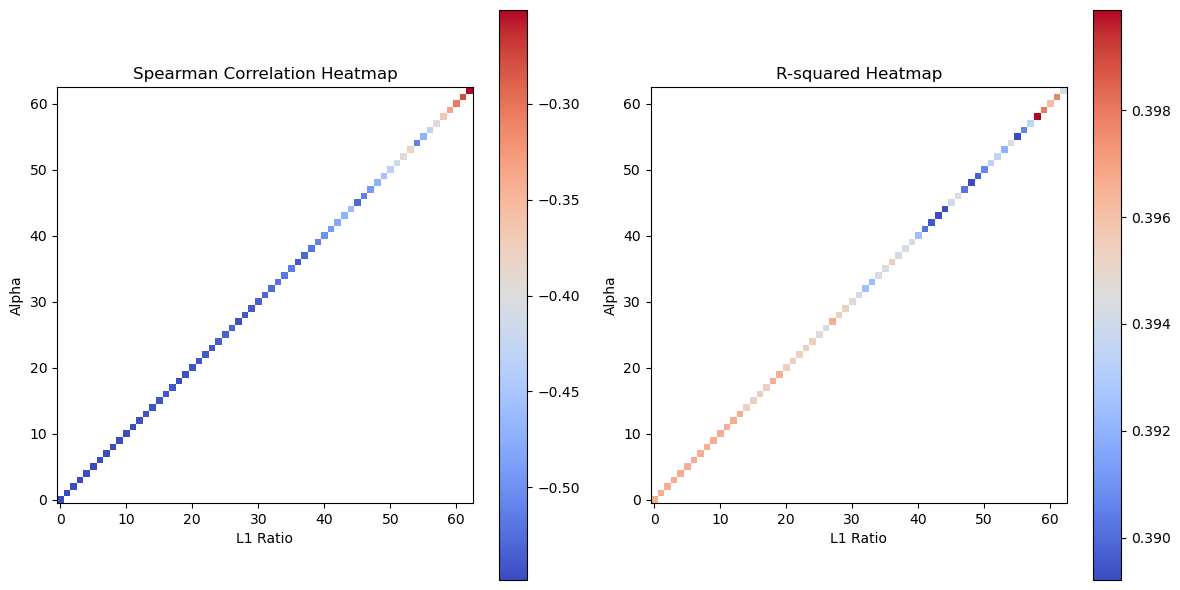

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Spearman heatmap
spearman_pivot = results_df.pivot(columns=["alpha", "l1_ratio", "spearman"])
cax1 = ax[0].imshow(spearman_pivot, interpolation='nearest', origin='lower', cmap='coolwarm')
ax[0].set_title("Spearman Correlation Heatmap")
ax[0].set_xlabel("L1 Ratio")
ax[0].set_ylabel("Alpha")
fig.colorbar(cax1, ax=ax[0])

# R-squared heatmap
r2_pivot = results_df.pivot(columns=["alpha", "l1_ratio", "r2"])
cax2 = ax[1].imshow(r2_pivot, interpolation='nearest', origin='lower', cmap='coolwarm')
ax[1].set_title("R-squared Heatmap")
ax[1].set_xlabel("L1 Ratio")
ax[1].set_ylabel("Alpha")
fig.colorbar(cax2, ax=ax[1])

plt.tight_layout()
plt.show()

### Dimensionality Reduction and Scaling

In [8]:
pca = PCA(n_components=500, random_state=42)  # Retain top 500 components
X_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)

X_scaled = scaler.fit_transform(X_reduced) 
X_val_scaled = scaler.fit_transform(X_val_reduced)

In [9]:
spearman_corr_test, rmse_test, r2_test = run_elastic_net(X_scaled, Y_train, X_val_scaled, Y_test)

Spearman Correlation (KFold): 0.3233244827671942
RMSE (KFold): 0.09993996357666944
R-squared (KFold): 0.08597066065258596
Spearman Correlation (Test): 0.3148089196526958
RMSE (Test): 0.08256663615587125
R-squared (Test): 0.08934320401834339


Select K Best seems to be doing a better job than PCA with 500 components